In [ ]:
import numpy as np
import random, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pandas as pd

min value of random img 0.0
max value of random img 0.9098039


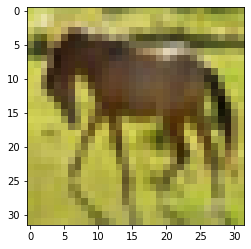

In [129]:
random_filename = random.choice([
    x for x in os.listdir("data/")
    if os.path.isfile(os.path.join("data/", x))
])
img = mpimg.imread("data/" + random_filename)
print("min value of random img", img.min())
print("max value of random img", img.max())
imgplot = plt.imshow(img)

min value of random img 10
max value of random img 221


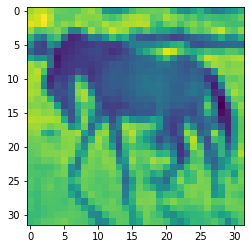

In [130]:
import cv2
img2 = cv2.imread("data/" + random_filename,0)
print("min value of random img", img2.min())
print("max value of random img", img2.max())
imgplot = plt.imshow(img2)

In [148]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [166]:
from skimage import io
# img = io.imread('image.png', as_gray=True)
images = [io.imread(file, as_gray=True) for file in glob.glob("data/*.png")]

In [167]:
x = pd.DataFrame(np.array(images).reshape(10000, -1))
y = pd.read_csv('labels.csv')

In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

cat


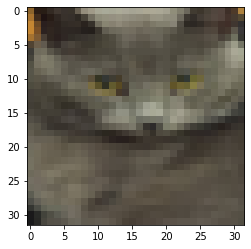

In [170]:
random_cat = (y_train[y_train['label'] == 'cat']).sample(1)
print(random_cat['label'].iloc[0])
img = mpimg.imread("des/data/" + str(random_cat['id'].iloc[0])+".png")
imgplot = plt.imshow(img)

horse


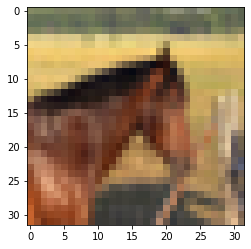

In [171]:
random_cat = y_train[y_train['label'] == 'horse'].sample(1)
print(random_cat['label'].iloc[0])
img = mpimg.imread("des/data/" + str(random_cat['id'].iloc[0])+".png")
imgplot = plt.imshow(img)

In [172]:
len(y_train[y_train['label'] == 'horse']), len(y_train[y_train['label'] == 'cat'])

(3446, 3554)

In [173]:
len(y_test[y_test['label'] == 'horse']), len(y_test[y_test['label'] == 'cat'])

(1554, 1446)

Text(0.5, 1.0, 'horse')

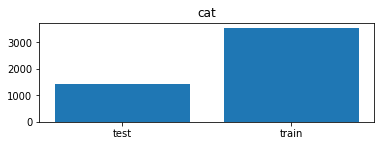

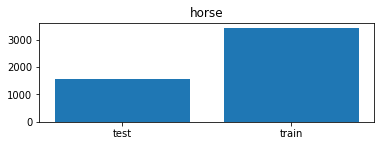

In [174]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.bar(['test', 'train'], [len(y_test[y_test['label'] == 'cat']), len(y_train[y_train['label'] == 'cat'])])
plt.title("cat")
fig = plt.figure()
ax = fig.add_subplot(212)
ax.bar(['test', 'train'], [len(y_test[y_test['label'] == 'horse']), len(y_train[y_train['label'] == 'horse'])])
plt.title("horse")

In [175]:
y_train = y_train.iloc[:, 1]
y_test = y_test.iloc[:, 1]

In [176]:
from sklearn.preprocessing import OneHotEncoder 
import random as rand

# Dataloader

In [191]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        encoder = OneHotEncoder(categories = 'auto')
        X = encoder.fit_transform(labels.values.reshape(-1,1)).toarray()
        onehot_vectors = pd.DataFrame(X)
        return onehot_vectors
    
    def __shuffle_dataset(self):
        rand = np.random.permutation(len(self.__data))
        self.__data = self.__data[rand]
        self.__onehot_labels = self.__onehot_labels[rand]
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [204]:
class Identical:
    
    
    def __init__(self): pass
        
    def __val(self, matrix):
        
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        
        return self.__val(matrix)
    

class Relu:
    
    
    def __init__(self): pass
        
    
    def __val(self, matrix):

        relu_value = np.matrix(matrix, dtype=float)
        relu_value[relu_value<0] = 0.0
        return relu_value

    def derivative(self, matrix):

        relu_derivative = np.matrix(matrix, dtype=float)
        relu_derivative[relu_derivative > 0] = 1.
        relu_derivative[relu_derivative < 0] = 0.
        return relu_derivative
    
    def __call__(self, matrix):
        
        return self.__val(matrix)

    
class LeakyRelu:
    
    
    def __init__(self, negative_slope=0.01):
        
        self.negative_slope = 0.01
    
    def __val(self, matrix):

       
        leacky_relu_value = np.matrix(matrix, dtype=float)
        leacky_relu_value = np.where(leacky_relu_value > 0, leacky_relu_value, 0.1 * leacky_relu_value)
        return leacky_relu_value

    def derivative(self, matrix):

        leacky_relu_derivative = np.matrix(matrix, dtype=float)
        leacky_relu_derivative = np.where(leacky_relu_derivative > 0., 1, 0.1 )
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        
        return self.__val(matrix)

    
class Sigmoid:
    
    
    def __init__(self): pass

    def __val(self, matrix):

        sigmoid_value = np.negative(matrix, dtype=float)
        sigmoid_value = np.matrix(1./(1 + np.exp(sigmoid_value)), dtype = float)
        return sigmoid_value

    def derivative(self, matrix):

        sigmoid_value = np.negative(matrix, dtype=float)
        sigmoid_value = np.matrix(1./(1 + np.exp(sigmoid_value)), dtype = float)
        sigmoid_value_minus_one = np.matrix(sigmoid_value + (-1))
        sigmoid_derivative = np.multiply(np.squeeze(sigmoid_value), np.squeeze(sigmoid_value_minus_one), out=None) 
        return sigmoid_derivative
    
    def __call__(self, matrix):
        
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass
        
    def __val(self, matrix):

        matrix -= np.column_stack((matrix.max(1),  matrix.max(1)))
        
        softmax_value = np.matrix(np.exp(matrix)/np.column_stack((np.exp(matrix).sum(1), np.exp(matrix).sum(1))), dtype=float)
        return softmax_value
    
    def __call__(self, matrix):
        
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass
      
    def __val(self, matrix):

        temp = np.matrix(matrix, dtype=float)
        tanh_value = np.tanh(temp)
        return tanh_value

    def derivative(self, matrix):

        tanh_value = self.__val(matrix)
        tanh_derivative = 1 - np.multiply(tanh_value, tanh_value)
        return tanh_derivative
    
    def __call__(self, matrix):
        
        return self.__val(matrix)

# Loss Function

In [193]:
class CrossEntropy: #(with softmax)
    
    
    def __init__(self): pass
        

    def __val(self, true_val, expected_val):
        
        assert np.shape(true_val)==np.shape(expected_val)
        s = Softmax()(true_val)
        cross_entropy_value = np.sum(-np.multiply(np.matrix(expected_val, dtype=float),np.log(s)), axis=1)
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        
        assert np.shape(true_val)==np.shape(expected_val)

        s = Softmax()(true_val)
        cross_entropy_derivative = s - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        
        return self.__val(true_val, expected_val)

# Layer

In [209]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):

        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):

        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)

        self.__last_input = layer_input
        self.__last_activation_input = np.matmul(layer_input, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):

        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        # TODO: Implement
        tp = self.__last_input.transpose()
        errory = np.multiply(backprop_tensor,self.__last_activation_derivative)
        errorw = np.matmul(tp,errory)
        backprop_tensor = np.matmul(errory,self.__weight.transpose())
        self.__weight -= errorw*lr
        bu = np.matmul(np.matrix(np.tile(1, (1, errory.shape[0]))),errory)
        self.__bias -= bu*lr
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):

        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.random.uniform(low = low, high = high, size = (dim1, dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):

        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement
        weights = [[0]* dim2] * dim1
        sd = np.sqrt(var)
        for i in range(dim1):
            for j in range(dim2):
                weights[i][j] = np.float32(rand.normal(0.0, sd))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# FNN

In [195]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        for i in self.__layers_list:
            network_output = i.forward(network_input)
            network_input = network_output
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):

        output = self.forward(x_batch)
        self.__update_weights(output, y_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = np.mean(self.__loss.__call__(output, y_batch))
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):

        output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = np.mean(self.__loss.__call__(output, y_batch))
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):

        labels = outputs.argmax(axis=1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):

        output = np.array(output)
        _output = np.argmax(output, axis=1)
        expected_output = np.array(expected_output)
        _expected_output = np.argmax(expected_output, axis=1)
        truePrediced = np.sum(_output == _expected_output)
        accuracy = truePrediced/len(_output)*100
        return accuracy
    
    
    def __update_weights(self, output, y_train):

        temp = self.__loss.derivative(output, y_train)
        for i in reversed(self.__layers_list):
            temp = i.update_weights(temp, self.__lr)
        return

# Test

In [210]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.001
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 32)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


	Train: Average Accuracy: 49.980974124809734	Average Loss: nan
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.6995182992492676
Epoch 2:
	Train: Average Accuracy: 50.90848554033485	Average Loss: 0.6963541919092406
	Test: Average Accuracy: 51.684397163120565	Average Loss: 0.6942104600909272
Epoch 3:
	Train: Average Accuracy: 50.342465753424655	Average Loss: 0.6939364561717202
	Test: Average Accuracy: 51.57358156028369	Average Loss: 0.6932307497252439
Epoch 4:
	Train: Average Accuracy: 51.27473363774734	Average Loss: 0.6930707506026049
	Test: Average Accuracy: 51.42952127659574	Average Loss: 0.6931544329870621
Epoch 5:
	Train: Average Accuracy: 51.77416286149163	Average Loss: 0.6925737999656753
	Test: Average Accuracy: 51.628989361702125	Average Loss: 0.6931712786171056
Epoch 6:
	Train: Average Accuracy: 52.0880898021309	Average Loss: 0.6921800304052655
	Test: Average Accuracy: 51.36303191489362	Average Loss: 0.6933225659987731
Epoch 7:
	Train: Average Accuracy: 52.40201674277

In [197]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.01
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 32)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, True)

Epoch 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


	Train: Average Accuracy: 49.92389649923896	Average Loss: nan
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.6929690369545634
Epoch 2:
	Train: Average Accuracy: 49.92389649923896	Average Loss: 0.6946608976457601
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.6929690369545634
Epoch 3:
	Train: Average Accuracy: 49.92389649923896	Average Loss: 0.6946608976457601
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.6929690369545634
Epoch 4:
	Train: Average Accuracy: 49.92389649923896	Average Loss: 0.6946608976457601
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.6929690369545634
Epoch 5:
	Train: Average Accuracy: 49.92389649923896	Average Loss: 0.6946608976457601
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.6929690369545634
Epoch 6:
	Train: Average Accuracy: 49.92389649923896	Average Loss: 0.6946608976457601
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.6929690369545634
Epoch 7:
	Train: Average Accuracy: 49.92389649923896

In [198]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.0001
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 32)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, True)

Epoch 1:
	Train: Average Accuracy: 49.9476788432268	Average Loss: 20.52480079640831
	Test: Average Accuracy: 51.75088652482269	Average Loss: 27.83139379233007
Epoch 2:
	Train: Average Accuracy: 50.50418569254186	Average Loss: 15.832199871118126
	Test: Average Accuracy: 51.75088652482269	Average Loss: 22.245031779815747
Epoch 3:
	Train: Average Accuracy: 50.18074581430745	Average Loss: 12.548161236304079
	Test: Average Accuracy: 51.75088652482269	Average Loss: 1.279587212662533
Epoch 4:
	Train: Average Accuracy: 50.35197869101978	Average Loss: 9.448129515239819
	Test: Average Accuracy: 48.24911347517731	Average Loss: 5.614732407593026
Epoch 5:
	Train: Average Accuracy: 50.646879756468806	Average Loss: 7.311761091343842
	Test: Average Accuracy: 51.75088652482269	Average Loss: 9.512705254580444
Epoch 6:
	Train: Average Accuracy: 50.618340943683414	Average Loss: 5.693924616599017
	Test: Average Accuracy: 51.75088652482269	Average Loss: 7.097131383906906
Epoch 7:
	Train: Average Accuracy: 5

In [199]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.001
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 32)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, True)

Epoch 1:
	Train: Average Accuracy: 51.407914764079145	Average Loss: 1.2327070833891471
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037891950480863
Epoch 2:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.233269345171558
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037891606877237
Epoch 3:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.2332692828590395
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037891263614543
Epoch 4:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.233269220310372
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037890920692161
Epoch 5:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.2332691575267656
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037890578109465
Epoch 6:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.2332690945094178
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037890235865835
Epoch 7:
	Train: Average Accu

In [202]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.001
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 32)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=Tanh(), weight_initializer='normal')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, True)

Epoch 1:
	Train: Average Accuracy: 50.89421613394216	Average Loss: 1.2677679164236373
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037905649028744
Epoch 2:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.2334764427215006
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037905535690592
Epoch 3:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.2334764773801132
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037905422330004
Epoch 4:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.233476512053466
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037905308946891
Epoch 5:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.233476546741615
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037905195541176
Epoch 6:
	Train: Average Accuracy: 51.35083713850837	Average Loss: 1.2334765814446018
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7037905082112768
Epoch 7:
	Train: Average Accur

In [203]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.001
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 32)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, True)

Epoch 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


	Train: Average Accuracy: 50.26636225266362	Average Loss: nan
	Test: Average Accuracy: 51.75088652482269	Average Loss: 0.7001748680778034
Epoch 2:
	Train: Average Accuracy: 50.48040334855403	Average Loss: 0.6962670922545975
	Test: Average Accuracy: 51.684397163120565	Average Loss: 0.6945881198701939
Epoch 3:
	Train: Average Accuracy: 50.932267884322684	Average Loss: 0.6939118989251211
	Test: Average Accuracy: 51.4738475177305	Average Loss: 0.6934028408998376
Epoch 4:
	Train: Average Accuracy: 51.560121765601224	Average Loss: 0.6930342492318414
	Test: Average Accuracy: 51.329787234042556	Average Loss: 0.6932179340423938
Epoch 5:
	Train: Average Accuracy: 52.202245053272456	Average Loss: 0.6925294340503956
	Test: Average Accuracy: 51.36303191489362	Average Loss: 0.6932525480078378
Epoch 6:
	Train: Average Accuracy: 52.416286149162865	Average Loss: 0.6921545006156639
	Test: Average Accuracy: 51.72872340425532	Average Loss: 0.6934410020010229
Epoch 7:
	Train: Average Accuracy: 52.715943683

In [207]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.001
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 16)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 16)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, True)

Epoch 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


	Train: Average Accuracy: 50.52796803652968	Average Loss: nan
	Test: Average Accuracy: 51.795212765957444	Average Loss: 0.7038060611527935
Epoch 2:
	Train: Average Accuracy: 50.94178082191781	Average Loss: 0.7002131976637403
	Test: Average Accuracy: 51.795212765957444	Average Loss: 0.6990974113037585
Epoch 3:
	Train: Average Accuracy: 51.08447488584475	Average Loss: 0.6952150259027623
	Test: Average Accuracy: 51.69547872340426	Average Loss: 0.6951615008265325
Epoch 4:
	Train: Average Accuracy: 51.09874429223744	Average Loss: 0.6936331437065485
	Test: Average Accuracy: 51.828457446808514	Average Loss: 0.693785455482477
Epoch 5:
	Train: Average Accuracy: 51.55536529680365	Average Loss: 0.6929019800236341
	Test: Average Accuracy: 51.795212765957444	Average Loss: 0.6934145620972518
Epoch 6:
	Train: Average Accuracy: 51.72659817351598	Average Loss: 0.692402572127422
	Test: Average Accuracy: 51.994680851063826	Average Loss: 0.6934668908495198
Epoch 7:
	Train: Average Accuracy: 52.04052511415

In [208]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.001
EPOCHS = 25
TRAINLOADER = Dataloader(X_train, y_train, n_classes = 2, batch_size = 256)
TESTLOADER = Dataloader(X_test, y_test, n_classes = 2, batch_size = 256)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(200, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, True)

Epoch 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


	Train: Average Accuracy: 49.24031047077922	Average Loss: nan
	Test: Average Accuracy: 48.2804008152174	Average Loss: 12.085565266894507
Epoch 2:
	Train: Average Accuracy: 50.09004667207792	Average Loss: 28.57715244195313
	Test: Average Accuracy: 51.7195991847826	Average Loss: 0.8071812773013868
Epoch 3:
	Train: Average Accuracy: 51.26192167207792	Average Loss: 3.6408591269460877
	Test: Average Accuracy: 48.24784873188406	Average Loss: 0.7885425902731042
Epoch 4:
	Train: Average Accuracy: 48.20667613636363	Average Loss: 0.8950136675003326
	Test: Average Accuracy: 51.7195991847826	Average Loss: 0.6928317627834278
Epoch 5:
	Train: Average Accuracy: 48.639153814935064	Average Loss: 0.713462746088967
	Test: Average Accuracy: 48.312952898550726	Average Loss: 0.6934014427556631
Epoch 6:
	Train: Average Accuracy: 48.443841314935064	Average Loss: 0.7069699644607157
	Test: Average Accuracy: 48.2804008152174	Average Loss: 0.6936263059663249
Epoch 7:
	Train: Average Accuracy: 48.80656452922078	Av